# User Defined Functions (UDFs)
Another functionality of OpenEO is providing the back-end with User Defined Functions and execute them.

In [16]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import sys
import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

In [17]:
con  = openeo.connect("https://openeo.vito.be").authenticate_oidc(provider_id="egi")
dates = ("2020-06-01", "2020-10-01")

#load the TOC reflectance Data Cube
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04", "B08", "SCL"])
cube = cube.filter_temporal(dates)

#define masking kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

#apply the scene classification, mask on vegetation and bare soil
classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

#Load Red, NIR, and calculate NDVI
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

Authenticated using refresh token.


We now use a UDF to interpolate the missing values and to apply a Savitzky-Golay filter for smoothing of the timeseries, using ```scipy.signal.savgol_filter```.

In [18]:
udf_code = """
from scipy.signal import savgol_filter
from openeo_udf.api.datacube import DataCube

def apply_datacube(cube: DataCube, context: dict) -> DataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""

smoothed_ndvi = masked_ndvi.apply_dimension(code=udf_code, runtime="Python", dimension="t")

Aggregate this per field, get the time series, and plot these.

In [22]:
DEFAULT_FIGSIZE = (5, 4)

def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    
    ts.index = pd.to_datetime(ts.index)
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ts.plot(marker='o', ax=ax)
    ax.set_title("Average NDVI"); 
    ax.set_ylabel("NDVI");
    ax.set_ylim(-0.05, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

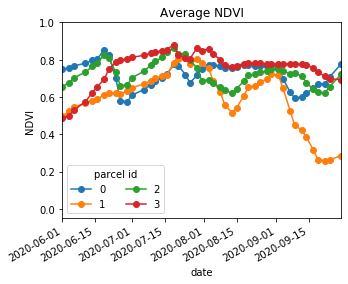

In [23]:
#get the fields from the GeoJSON
with open("fields.geojson") as f:
    features = json.load(f)["features"]
    fields = shapely.geometry.GeometryCollection([shapely.geometry.shape(ftr["geometry"]) for ftr in features])

smoothed_timeseries = smoothed_ndvi.aggregate_spatial(geometries=fields, reducer="mean")
smoothed_timeseries.download("timeseries-smoothed.json", format="JSON")
plot_timeseries("timeseries-smoothed.json")